### Классификация активностей человека

Рассмотрим задачу классификации набора данных, содержащего временные ряды, с помощью DWT.

Набор данных UCI-HAR (Human Activity Recognition) содержит измерения датчиков людей, выполняющих различные виды физической активности, например, подъем или спуск по лестнице, лежание, стояние, ходьбу и т. д. Данные в наборе получены от тридцати добровольцев с закрепленным на поясе Samsung Galaxy S II. В датасете более 10 000 сигналов, каждый из которых состоит из девяти компонентов (ускорение x, ускорение y, ускорение z, данные гироскопа x,y,z и т. д.). 

Датасет доступен по ссылке:

https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

Сначала сформируем датасет для обучения. Для этого подгрузим сигналы и сделаем их НВП.

In [2]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from tqdm import tqdm

In [4]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(lambda x: int(x)-1, activities))
    return activities

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

INPUT_FOLDER_TRAIN = './HAR_Dataset/train/InertialSignals/'
INPUT_FOLDER_TEST = './HAR_Dataset/test/InertialSignals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABELFILE_TRAIN = './HAR_Dataset/train/y_train.txt'
LABELFILE_TEST = './HAR_Dataset/test/y_test.txt'

train_signals, test_signals = [], []

In [6]:
for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))

for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(test_signals)
no_labels = len(np.unique(train_labels[:]))

print("Обучающая выборка состоит из {} сигналов, каждый сигнал длины {} и из {} компонент ".format(no_signals_train, no_steps_train, no_components_train))
print("Тестовая выборка состоит из {} сигналов, каждый сигнал длины {} и из {} компонент ".format(no_signals_test, no_steps_test, no_components_test))
print("Обучающая выборка состоит из {} меток классов с распределением:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))
print("Тестовая выборка состоит из {} меток классовс распределением:\n {}".format(np.shape(test_labels)[0], Counter(test_labels[:])))

uci_har_signals_train, uci_har_labels_train = randomize(train_signals, np.array(train_labels))
uci_har_signals_test, uci_har_labels_test = randomize(test_signals, np.array(test_labels))

Обучающая выборка состоит из 7352 сигналов, каждый сигнал длины 128 и из 9 компонент 
Тестовая выборка состоит из 2947 сигналов, каждый сигнал длины 128 и из 9 компонент 
Обучающая выборка состоит из 7352 меток классов с распределением:
 Counter({5: 1407, 4: 1374, 3: 1286, 0: 1226, 1: 1073, 2: 986})
Тестовая выборка состоит из 2947 меток классовс распределением:
 Counter({5: 537, 4: 532, 0: 496, 3: 491, 1: 471, 2: 420})


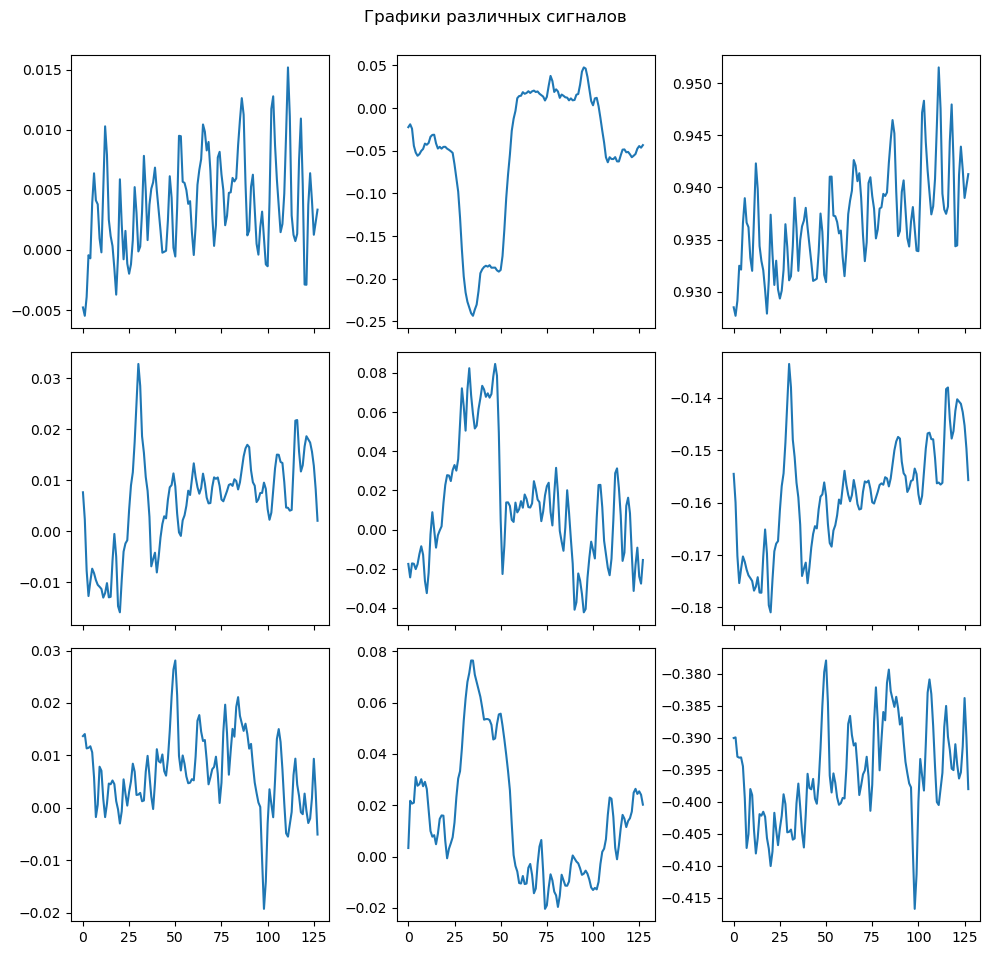

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10), sharex=True)
x = np.arange(0, 128, 1.0)
for i in range(3):
    for j in range(3):
        axs[i, j].plot(x, uci_har_signals_train[0,:,i+3*j])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Графики различных сигналов")
plt.show()

In [20]:
signal = uci_har_signals_train[0, :, 0]
coeffs = pywt.wavedec(signal, 'db4', level=4, mode = 'reflect')
arr, coeff_slices = pywt.coeffs_to_array(coeffs)

In [22]:
cA4, cD4, cD3, cD2, cD1 = coeffs

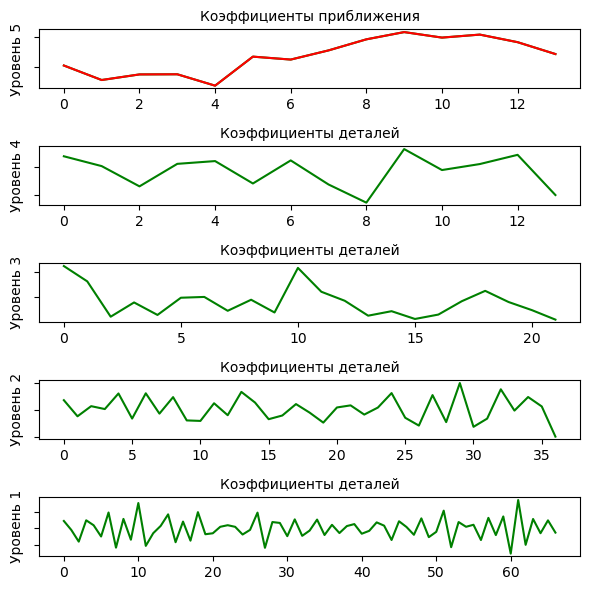

In [28]:
fig, axarr = plt.subplots(nrows=5, ncols=1, figsize=(6,6))
for ind, coef in enumerate(coeffs):    
    axarr[ind].plot(coef,'g')

    axarr[ind].set_ylabel("Уровень {}".format(5-ind), fontsize=10, rotation=90)
    axarr[ind].set_yticklabels([])
    axarr[ind].set_title("Коэффициенты деталей", fontsize=10)
    if ind == 0:
        axarr[ind].plot(coef, 'r')
        axarr[ind].set_ylabel("Уровень {}".format(5), fontsize=10, rotation=90)
        axarr[ind].set_title("Коэффициенты приближения", fontsize=10)
        
    axarr[ind].set_yticklabels([])
plt.tight_layout()
plt.show()

In [16]:
coeff_slices

[(slice(None, 14, None),),
 {'d': (slice(14, 28, None),)},
 {'d': (slice(28, 50, None),)},
 {'d': (slice(50, 87, None),)},
 {'d': (slice(87, 154, None),)}]

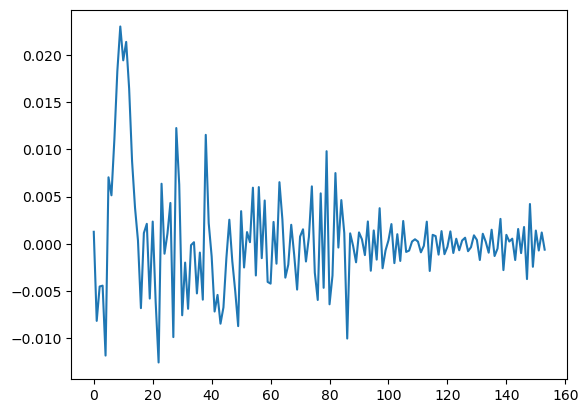

In [18]:
plt.plot(arr)

### Задача. 

Сформировать полносвязную ИНС и обучить на датасете `(train_data_dwt, target_train)`.

Точность на тестовом датасете не меньше 95%.

Для каждого обучающего примера надо вычислить результаты ДВП от 9 сигналов. Затем их можно расположить в виде вектора и подать на вход ИНС.

Сформированные массивы с DWT можно сохранить.

In [169]:
with open('data_train.npy', 'wb') as f:
    np.save(f, train_data_dwt)
with open('data_test.npy', 'wb') as f:
    np.save(f, test_data_dwt)

In [194]:
with open('data_train.npy', 'rb') as f:
    train_data_dwt = np.load(f)
with open('data_test.npy', 'rb') as f:
    test_data_dwt = np.load(f)

Сформируем обучающий и тестовый датасеты.

In [62]:
x_train = train_data_dwt
y_train = list(uci_har_labels_train[:train_size])
x_test = test_data_dwt
y_test = list(uci_har_labels_test[:test_size])
num_classes = 6

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (7352, 783)
7352 train samples
2947 test samples


В векторах `y_train` и `y_test` содержатся индексы тех или иных активностей. Переведём их в бинарные вектора методом one-hot encoding.

In [63]:
import torch
import torch.nn as nn

def encode_labels(labels, num_of_classes): 
    num = len(labels)
    target = torch.zeros(num, num_of_classes).float()
    for i, l in enumerate(labels):
        target[i, l] = 1
    return target

target_train = encode_labels(y_train, num_classes)
target_test = encode_labels(y_test, num_classes)

Сформировать свёрточную ИНС и обучить на датасете `(train_data_dwt, target_train)`.

Точность на тестовом датасете `(train_data_dwt, target_test)` не меньше 95%.